<a href="https://colab.research.google.com/github/PriyankaPVibhandik/Federated-Learning-based-Perception-of-IDC-in-Histopathological-images-with-the-use-of-Deep-Learning/blob/main/DenseNet_201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DenseNet-201

import libraries

In [ ]:
import json
import math
import os  # dealing with directories

import cv2 # working with, mainly resizing, images
from PIL import Image
import numpy as np  # dealing with arrays
from keras import layers
from keras.applications import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm   # a nice pretty percentage bar for tasks.
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
%matplotlib inline

upload the dataset

In [ ]:
from zipfile import ZipFile
file_name = '/content/Dataset.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


the code snippet defines a function Dataset_loader to read and resize images from a specified directory. It loads the images in the directory with a ".png" extension, resizes them to a specified size using OpenCV, and converts them into NumPy arrays. The function is then called to load the training and testing images for both the benign and malignant classes.

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/content/0',224))
malign_train = np.array(Dataset_loader('/content/1',224))
benign_test = np.array(Dataset_loader('/content/0',224))
malign_test = np.array(Dataset_loader('/content/1',224))
#benign_test = np.array(Dataset_loader('data/validation/benign',224))
#malign_test = np.array(Dataset_loader('data/validation/malignant',224))

100%|██████████| 70/70 [00:00<00:00, 1723.04it/s]


Create lable

this code snippet prepares the data for training and testing by merging the image data and labels, shuffling the data randomly, and converting the labels to one-hot encoded categorical format. This ensures that the data is properly prepared for training a model using the Densenet-201 architecture.

In [ ]:
# Skin Cancer: Malignant vs. Benign
# Create labels
#benign_train_label = np.zeros(len(benign_train))
#malign_train_label = np.ones(len(malign_train))
# benign_test_label = np.zeros(len(benign_test))
# malign_test_label = np.ones(len(malign_test))

benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# Train and Evalutation split


this code snippet splits the training data (X_train and Y_train) into two subsets: x_train and y_train for model training, and x_val and y_val for model validation. The data is split in a stratified manner, preserving the distribution of the classes. The specific proportion of the split is defined by test_size, and the random state is set for reproducibility.

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

# Display Some Images

this code snippet creates a grid of subplots and displays the first 15 images of moles from the training set along with their respective classifications. It provides a visual representation of the data and how it is classified as benign or malignant.

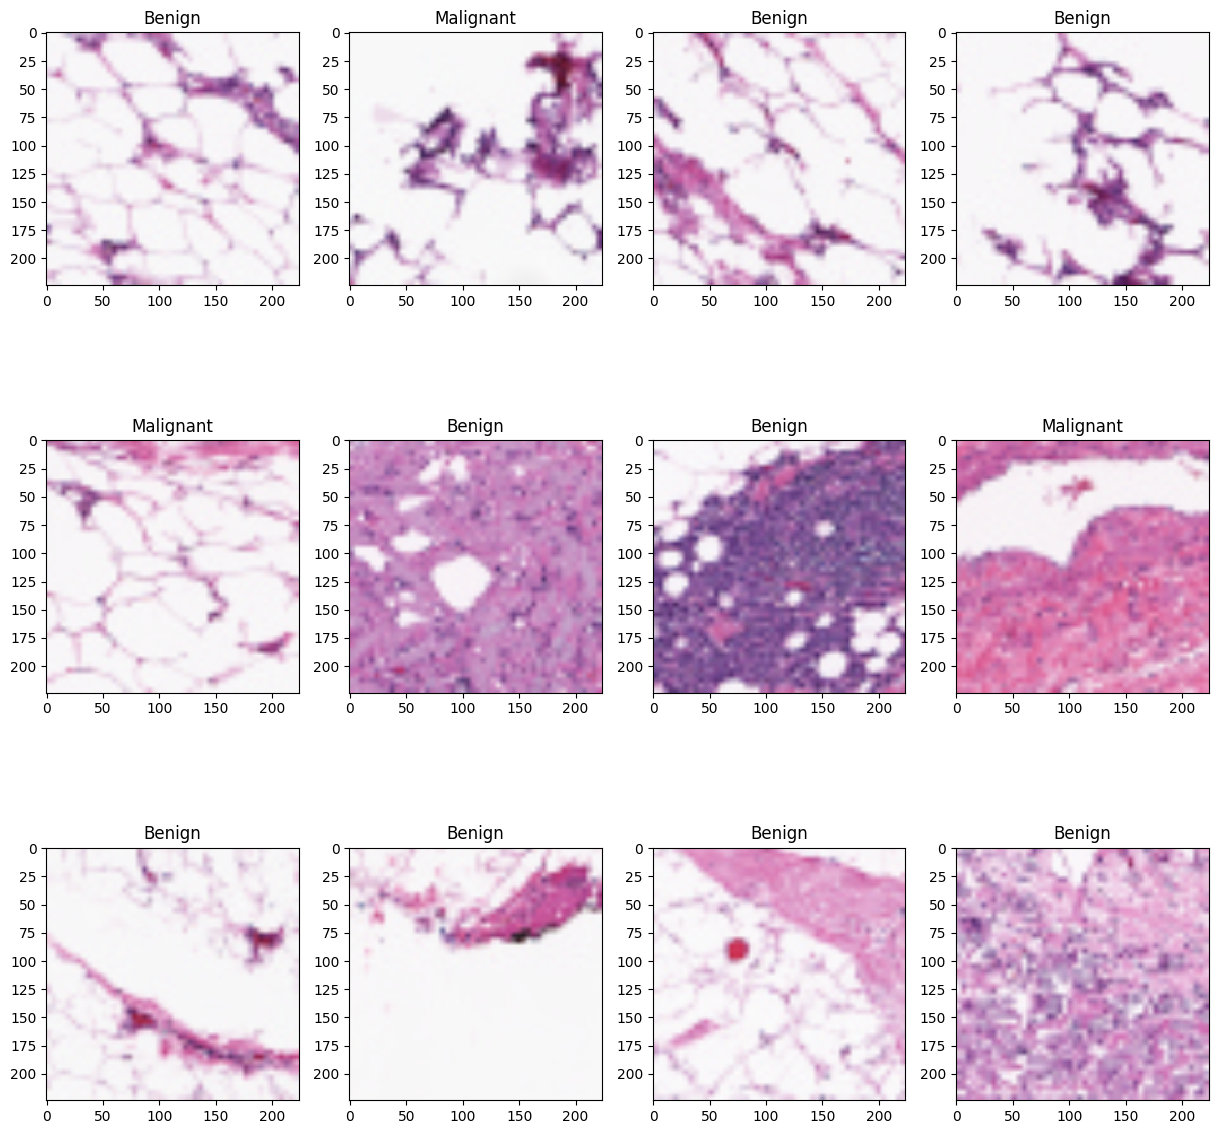

In [ ]:
# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Data Generator

In [ ]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Model: DenseNet-201

the build_model function creates a neural network model with a specified backbone, adds additional layers for pooling, regularization, normalization, and classification, and compiles the model with the appropriate loss function, optimizer, and metrics.

In [ ]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))


    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )

    return model

this code snippet initializes a DenseNet201 model with pre-trained weights, constructs a new model using the build_model function with the DenseNet201 as the backbone, and prints a summary of the model's architecture.

In [ ]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)



model = build_model(resnet ,lr = 1e-4)
model.summary()

74836368/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                         

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


these code snippets create two callbacks: ReduceLROnPlateau for reducing the learning rate based on validation accuracy and ModelCheckpoint for saving the best weights of the model during training. These callbacks help in optimizing the training process and allow us to save the model's progress.

In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
metric = 'val_accuracy'
checkpoint = ModelCheckpoint(filepath, monitor=metric, verbose=1, save_best_only=True, mode='max')  #monitor='val_acc'

# Training & Evaluation

The model.fit_generator() function then performs the training by fitting the model to the generated batches of data. It returns a history object that contains information about the training process, such as loss and accuracy values at each epoch.

In [ ]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

<ipython-input-13-b7b960b0426a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
28/27 [==============================] - ETA: -11s - loss: 0.6430 - accuracy: 0.6697


Epoch 1: val_accuracy improved from -inf to 0.97273, saving model to weights.best.hdf5
27/27 [==============================] - 681s 24s/step - loss: 0.6430 - accuracy: 0.6697 - val_loss: 0.3368 - val_accuracy: 0.9727 - lr: 1.0000e-04
Epoch 2/20
28/27 [==============================] - ETA: -11s - loss: 0.4823 - accuracy: 0.8109


Epoch 2: val_accuracy did not improve from 0.97273
27/27 [==============================] - 615s 22s/step - loss: 0.4823 - accuracy: 0.8109 - val_loss: 0.4350 - val_accuracy: 0.8727 - lr: 1.0000e-04
Epoch 3/20
28/27 [==============================] - ETA: -11s - loss: 0.4035 - accuracy: 0.8793


Epoch 3: val_accuracy did not improve from 0.97273
27/27 [==============================] - 607s 22s/step - loss: 0.4035 - accuracy: 0.8793 - val_loss: 0.4968 - val_accuracy: 0.8455 - lr: 1.0000e-04
Epoch 4/20
28/27 [==============================] - ETA: -11s - loss: 0.3662 - accuracy: 0.9066


Epoch 4: val_accuracy did not improve from 0.97273
27/27 [==============================] - 588s 21s/step - loss: 0.3662 - accuracy: 0.9066 - val_loss: 0.7022 - val_accuracy: 0.7818 - lr: 1.0000e-04
Epoch 5/20
28/27 [==============================] - ETA: -11s - loss: 0.3477 - accuracy: 0.9043


Epoch 5: val_accuracy did not improve from 0.97273
27/27 [==============================] - 601s 22s/step - loss: 0.3477 - accuracy: 0.9043 - val_loss: 1.5509 - val_accuracy: 0.3182 - lr: 1.0000e-04
Epoch 6/20
28/27 [==============================] - ETA: -11s - loss: 0.3053 - accuracy: 0.9203


Epoch 6: val_accuracy did not improve from 0.97273
27/27 [==============================] - 585s 21s/step - loss: 0.3053 - accuracy: 0.9203 - val_loss: 0.7614 - val_accuracy: 0.8182 - lr: 1.0000e-04
Epoch 7/20
28/27 [==============================] - ETA: -11s - loss: 0.2536 - accuracy: 0.9294


Epoch 7: val_accuracy did not improve from 0.97273
27/27 [==============================] - 602s 22s/step - loss: 0.2536 - accuracy: 0.9294 - val_loss: 0.4521 - val_accuracy: 0.9273 - lr: 1.0000e-04
Epoch 8/20
28/27 [==============================] - ETA: -11s - loss: 0.2945 - accuracy: 0.9408


Epoch 8: val_accuracy did not improve from 0.97273
27/27 [==============================] - 599s 22s/step - loss: 0.2945 - accuracy: 0.9408 - val_loss: 0.8434 - val_accuracy: 0.8364 - lr: 1.0000e-04
Epoch 9/20
28/27 [==============================] - ETA: -11s - loss: 0.2360 - accuracy: 0.9408


Epoch 9: val_accuracy did not improve from 0.97273
27/27 [==============================] - 595s 22s/step - loss: 0.2360 - accuracy: 0.9408 - val_loss: 0.7629 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 10/20
28/27 [==============================] - ETA: -11s - loss: 0.2266 - accuracy: 0.9453


Epoch 10: val_accuracy did not improve from 0.97273
27/27 [==============================] - 596s 22s/step - loss: 0.2266 - accuracy: 0.9453 - val_loss: 0.5415 - val_accuracy: 0.8818 - lr: 1.0000e-04
Epoch 11/20
28/27 [==============================] - ETA: -11s - loss: 0.2132 - accuracy: 0.9613


Epoch 11: val_accuracy did not improve from 0.97273
27/27 [==============================] - 590s 22s/step - loss: 0.2132 - accuracy: 0.9613 - val_loss: 0.3074 - val_accuracy: 0.9273 - lr: 1.0000e-04
Epoch 12/20
28/27 [==============================] - ETA: -10s - loss: 0.2068 - accuracy: 0.9499


Epoch 12: val_accuracy did not improve from 0.97273
27/27 [==============================] - 589s 21s/step - loss: 0.2068 - accuracy: 0.9499 - val_loss: 0.4535 - val_accuracy: 0.9091 - lr: 1.0000e-04
Epoch 13/20
28/27 [==============================] - ETA: -10s - loss: 0.2209 - accuracy: 0.9271


Epoch 13: val_accuracy did not improve from 0.97273
27/27 [==============================] - 585s 21s/step - loss: 0.2209 - accuracy: 0.9271 - val_loss: 0.2548 - val_accuracy: 0.9545 - lr: 1.0000e-04
Epoch 14/20
28/27 [==============================] - ETA: -10s - loss: 0.2075 - accuracy: 0.9248


Epoch 14: val_accuracy did not improve from 0.97273
27/27 [==============================] - 586s 21s/step - loss: 0.2075 - accuracy: 0.9248 - val_loss: 0.2454 - val_accuracy: 0.9545 - lr: 1.0000e-04
Epoch 15/20
28/27 [==============================] - ETA: -11s - loss: 0.2408 - accuracy: 0.9248


Epoch 15: val_accuracy did not improve from 0.97273
27/27 [==============================] - 591s 22s/step - loss: 0.2408 - accuracy: 0.9248 - val_loss: 0.0819 - val_accuracy: 0.9727 - lr: 1.0000e-04
Epoch 16/20
28/27 [==============================] - ETA: -10s - loss: 0.1551 - accuracy: 0.9658


Epoch 16: val_accuracy did not improve from 0.97273
27/27 [==============================] - 585s 21s/step - loss: 0.1551 - accuracy: 0.9658 - val_loss: 0.1458 - val_accuracy: 0.9545 - lr: 1.0000e-04
Epoch 17/20
28/27 [==============================] - ETA: -11s - loss: 0.1470 - accuracy: 0.9522


Epoch 17: val_accuracy did not improve from 0.97273
27/27 [==============================] - 595s 22s/step - loss: 0.1470 - accuracy: 0.9522 - val_loss: 0.4117 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 18/20
28/27 [==============================] - ETA: -11s - loss: 0.1269 - accuracy: 0.9636


Epoch 18: val_accuracy did not improve from 0.97273
27/27 [==============================] - 600s 22s/step - loss: 0.1269 - accuracy: 0.9636 - val_loss: 0.2239 - val_accuracy: 0.9455 - lr: 1.0000e-04
Epoch 19/20
28/27 [==============================] - ETA: -11s - loss: 0.1665 - accuracy: 0.9476


Epoch 19: val_accuracy did not improve from 0.97273
27/27 [==============================] - 591s 22s/step - loss: 0.1665 - accuracy: 0.9476 - val_loss: 0.2410 - val_accuracy: 0.9364 - lr: 1.0000e-04
Epoch 20/20
28/27 [==============================] - ETA: -10s - loss: 0.1133 - accuracy: 0.9658


Epoch 20: val_accuracy did not improve from 0.97273
27/27 [==============================] - 589s 22s/step - loss: 0.1133 - accuracy: 0.9658 - val_loss: 0.3691 - val_accuracy: 0.9364 - lr: 1.0000e-04


In [ ]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

<Axes: >

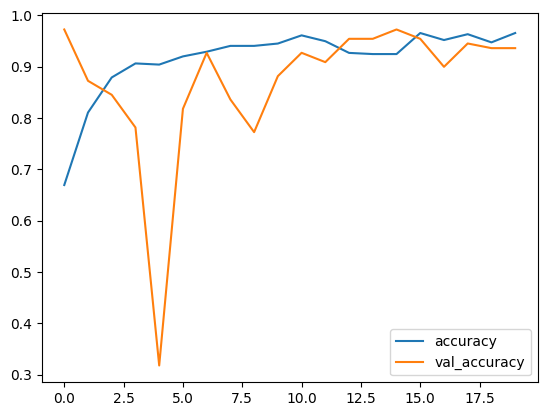

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

<Axes: >

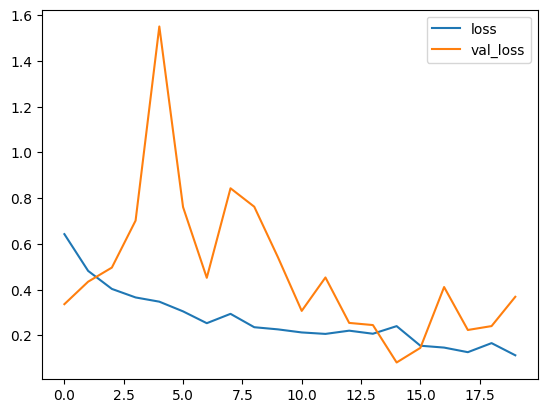

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Prediction

In [ ]:
model.load_weights("weights.best.hdf5")

In [ ]:
Y_val_pred = model.predict(x_val)

4/4 [==============================] - 27s 5s/step


 the code snippet calculates the accuracy score by comparing the true labels with the predicted labels and returns the accuracy of the classification model. The accuracy score provides a measure of how well the model is performing in terms of correctly predicting the class labels

In [ ]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.9727272727272728

In [ ]:
Y_pred = model.predict(X_test)

18/18 [==============================] - 122s 7s/step


this code snippet performs Test Time Augmentation by generating predictions for the test data using the trained model multiple times with different augmentations. The final predictions are obtained by averaging the predictions over all TTA steps.

In [ ]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)

    predictions.append(preds)
    gc.collect()

Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-23-6b1627227319>:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
100%|██████████| 10/10 [22:53<00:00, 137.31s/it]


### Confusion Matrix

this code snippet calculates the confusion matrix based on the true labels and predicted labels and then visualizes the confusion matrix using a plot. The confusion matrix provides insights into the performance of a classification model, showing the number of samples that are correctly and incorrectly classified for each class.

Confusion matrix, without normalization
[[476   3]
 [ 30  40]]


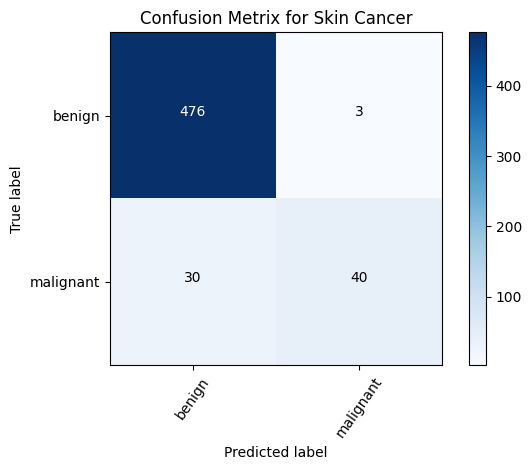

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Confusion matrix, without normalization
[[479   0]
 [ 50  20]]


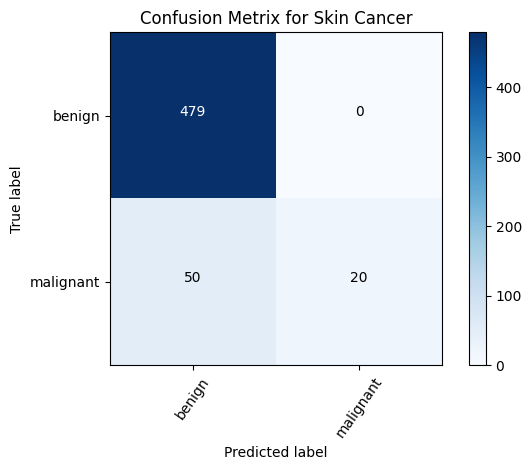

In [ ]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Classification Report

In [ ]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.91      1.00      0.95       479\n           1       1.00      0.29      0.44        70\n\n    accuracy                           0.91       549\n   macro avg       0.95      0.64      0.70       549\nweighted avg       0.92      0.91      0.89       549\n'

### ROC and AUC

this code snippet calculates the ROC AUC score, plots the ROC curve, and displays the curve with the corresponding AUC score. The ROC curve visualizes the trade-off between the true positive rate and the false positive rate for different classification thresholds, providing insights into the model's performance.

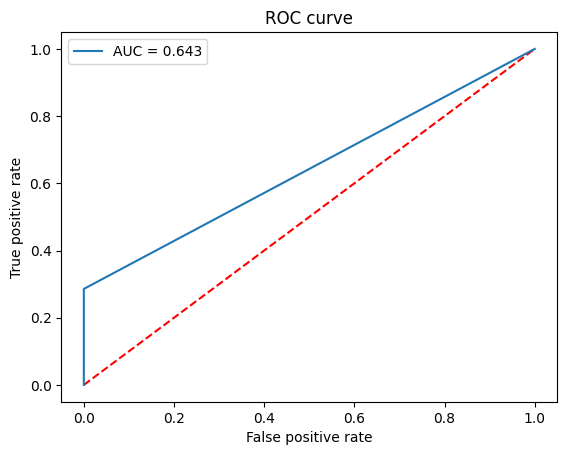

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

this code snippet identifies the indices of correctly classified and misclassified images, and then displays the first 8 correctly classified images with their predicted and actual labels. This can help in visually inspecting the model's performance and understanding which images are classified correctly.

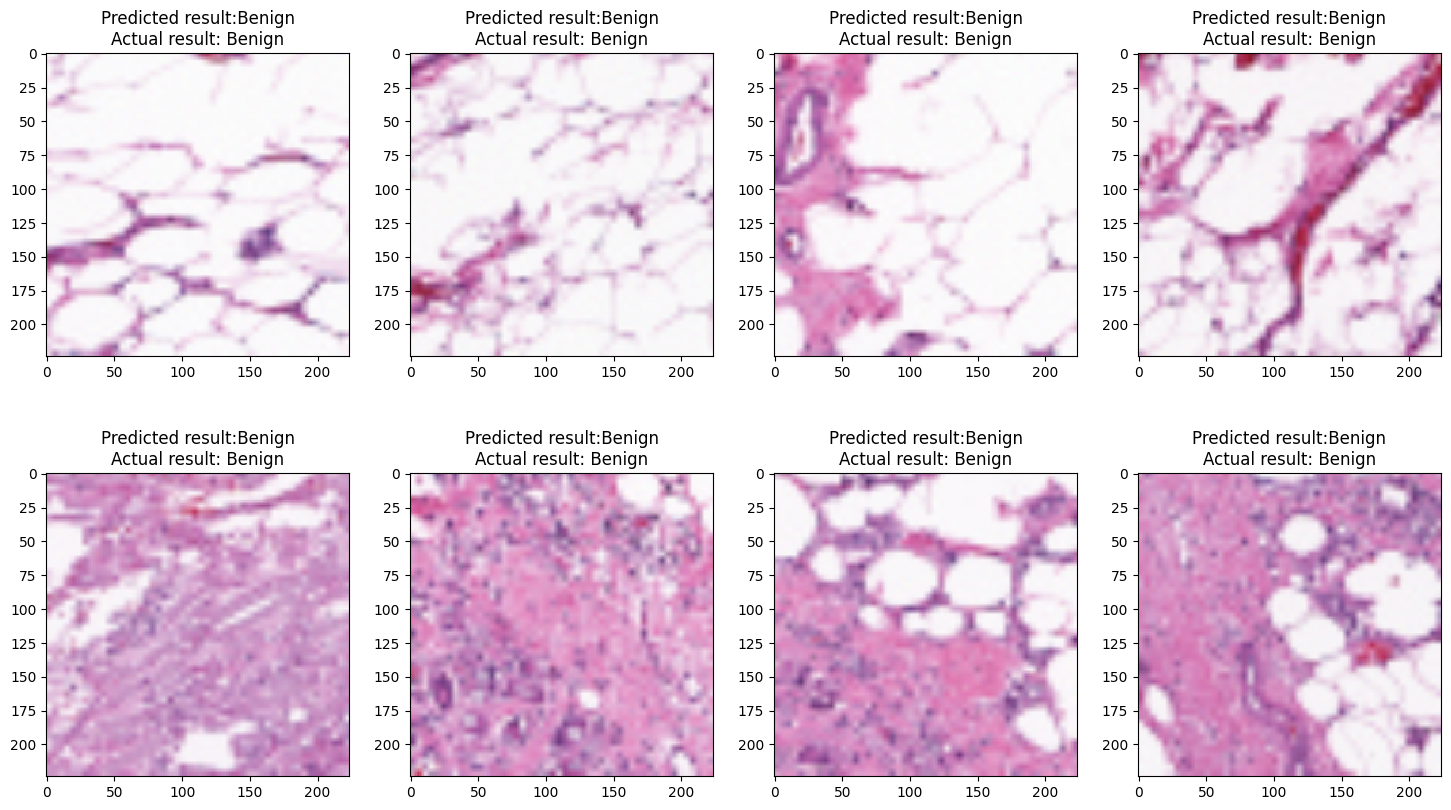

In [ ]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

Accuracy of this model is 91%

ROC and AUC

Certainly! ROC (Receiver Operating Characteristic) curve and AUC (Area Under the Curve) are commonly used metrics for evaluating the performance of binary classification models. Here's an explanation of each:

1. ROC Curve:
   - The ROC curve is a graphical representation of the performance of a binary classification model.
   - It plots the true positive rate (TPR) against the false positive rate (FPR) at various classification thresholds.
   - The TPR is also known as sensitivity or recall and represents the proportion of actual positive samples that are correctly classified as positive.
   - The FPR is the ratio of false positives to the total number of actual negatives and represents the proportion of actual negative samples that are incorrectly classified as positive.
   - The ROC curve shows the trade-off between the TPR and FPR as the classification threshold changes.
   - A good classifier will have a ROC curve that hugs the top left corner of the plot, indicating high TPR and low FPR across various thresholds.

2. AUC (Area Under the Curve):
   - AUC is a scalar value that represents the overall performance of a binary classification model summarized by the ROC curve.
   - It calculates the area under the ROC curve.
   - The AUC ranges from 0 to 1, where 0 represents a poor classifier and 1 represents a perfect classifier.
   - An AUC value of 0.5 suggests a random classifier that is no better than random guessing.
   - Higher AUC values indicate better classification performance, with 1 being the ideal case of perfect classification.

In summary, the ROC curve visually assesses the performance of a binary classifier at different classification thresholds, while the AUC provides a single numeric value representing the overall performance of the model. These metrics are useful for comparing different models, selecting appropriate classification thresholds, and understanding the trade-off between true positive and false positive rates.

DENSENET-201

DenseNet-201 is a deep convolutional neural network architecture that was introduced as an extension of the DenseNet family of models. It was designed to address the challenge of training very deep neural networks effectively by encouraging feature reuse and alleviating the vanishing gradient problem.

Here are some key characteristics of DenseNet-201:

1. Dense connectivity: DenseNet-201 is based on the concept of dense connectivity, where each layer is connected to every other layer in a feed-forward manner. This dense connectivity promotes information flow between layers and enables feature reuse, allowing the network to extract and propagate features efficiently.

2. Dense blocks: DenseNet-201 consists of multiple dense blocks, which are the main building blocks of the network. Each dense block contains several convolutional layers, and the output of each layer is concatenated with the feature maps of all preceding layers. This dense connection scheme facilitates gradient flow, improves feature propagation, and encourages feature reuse.

3. Transition layers: DenseNet-201 includes transition layers between dense blocks to reduce the spatial dimensions and control the number of feature maps. These transition layers consist of a combination of convolutional, pooling, and downsampling operations, which help in reducing the computational complexity of the network.

4. Bottleneck layers: To further enhance the efficiency of DenseNet-201, it uses bottleneck layers within each dense block. Bottleneck layers reduce the number of input feature maps before applying the dense connectivity, which helps in reducing the model's parameters and computational cost.

5. Pre-training and transfer learning: DenseNet-201 is often initialized with pre-trained weights obtained from training on large-scale image classification datasets, such as ImageNet. This pre-training enables transfer learning, where the network learns generic visual features from a large dataset and can be fine-tuned on smaller, task-specific datasets.

Overall, DenseNet-201 is known for its powerful feature extraction capabilities, efficient parameter usage, and high accuracy in various computer vision tasks, including image classification, object detection, and segmentation.

DenseNet-201 has a total of approximately 20 million trainable parameters. Here is a breakdown of the main parameter components:

1. Convolutional layers: DenseNet-201 consists of several convolutional layers, including the initial convolutional layer and the convolutional layers within each dense block. The exact number of convolutional layers in DenseNet-201 is 190.

2. Dense blocks: DenseNet-201 has four dense blocks, each containing multiple convolutional layers. The number of layers within each dense block is [6, 12, 48, 32] for the four blocks, respectively.

3. Bottleneck layers: Within each dense block, DenseNet-201 uses bottleneck layers to reduce the number of input feature maps before applying the dense connectivity. The bottleneck layers are 1x1 convolutional layers that reduce the number of input channels.

4. Transition layers: DenseNet-201 includes transition layers between dense blocks to reduce the spatial dimensions and control the number of feature maps. Each transition layer consists of a combination of convolutional, pooling, and downsampling operations.

5. Global Average Pooling layer: At the end of the network, DenseNet-201 applies a Global Average Pooling layer to convert the feature maps into a fixed-length feature vector. This pooling operation does not introduce any additional parameters.

6. Fully connected layer: DenseNet-201 concludes with a fully connected layer that maps the extracted features to the desired number of output classes. The number of units in the fully connected layer depends on the specific task and dataset.

It's important to note that the number of parameters may vary slightly depending on the implementation and any modifications made to the architecture.

In DenseNet-201, the number "201" refers to the total number of layers in the network. This includes convolutional layers, pooling layers, dense blocks, and transition layers.

To be more specific, the "201" in DenseNet-201 signifies that it has 201 layers in total, which is achieved by stacking multiple dense blocks with varying numbers of layers and transition layers in between.

The architecture of DenseNet-201 is deeper than its predecessors, such as DenseNet-121 and DenseNet-169, which have 121 and 169 layers, respectively. The increased depth in DenseNet-201 allows it to capture more complex patterns and features, making it suitable for tasks that require a higher level of representation learning, such as image classification on large and complex datasets.

In DenseNet-201, the 201 layers refer to the total number of layers in the entire network, including both convolutional layers and fully connected layers. These layers are distributed across different components of the network, namely the convolutional blocks (dense blocks) and the transition layers.

The dense blocks are the primary building blocks of DenseNet, and they consist of multiple convolutional layers stacked together. Each layer in a dense block receives inputs from all preceding layers within the same block. By densely connecting the layers, feature reuse and propagation are encouraged, allowing the network to efficiently learn and utilize information from earlier layers.

The transition layers are responsible for reducing the spatial dimensions (width and height) of the feature maps produced by the dense blocks. They typically consist of a combination of convolutional layers, pooling layers, and dimensionality reduction techniques. These layers help in compressing the feature maps and controlling the growth of the network by reducing the number of feature maps before passing them to the next dense block.

So, in summary, the 201 layers in DenseNet-201 are distributed among the convolutional layers in the dense blocks and the transition layers. They collectively contribute to the overall depth and representational capacity of the DenseNet-201 model.

Increasing the number of layers from 201 to 210 in DenseNet-201 would result in a deeper network architecture. Adding more layers can potentially increase the model's representational capacity and ability to capture more complex patterns and features in the data.

However, there are a few considerations to keep in mind when increasing the number of layers:

1. Computational Complexity: Adding more layers increases the computational cost of training and inference. Deeper networks require more memory and computational resources, which can lead to longer training times and higher resource requirements.

2. Overfitting: Deeper networks have a higher risk of overfitting, especially when the training dataset is small. Overfitting occurs when the model becomes too complex and starts to memorize the training data instead of learning generalizable patterns. Regularization techniques like dropout and weight decay may be necessary to mitigate overfitting.

3. Gradient Vanishing or Exploding: Very deep networks can suffer from the gradient vanishing or exploding problem during backpropagation, which can make training difficult. Techniques like skip connections (used in DenseNet) and careful initialization can help alleviate this issue.

4. Training Data Size: Deeper networks generally require more training data to effectively learn the complex patterns. If the dataset is small, increasing the number of layers may not provide significant improvements and could lead to overfitting.

In summary, increasing the number of layers from 201 to 210 in DenseNet-201 can potentially enhance the model's capacity to capture intricate features. However, it is important to consider computational resources, overfitting, gradient-related issues, and the availability of sufficient training data before deciding on the depth of the network.

DenseNet-201 is a deep convolutional neural network architecture, and its space consumption and time execution depend on several factors, including the hardware used, the implementation, and the size of the input data. However, some general observations can be made:

1. Space Consumption: The space consumption of DenseNet-201 is primarily determined by the number of parameters in the model. DenseNet-201 has approximately 20 million parameters, which means it requires a significant amount of memory to store the weights and biases of the network. The exact memory requirement may vary based on the implementation and the data type used (e.g., 16-bit or 32-bit floating-point precision).

2. Time Execution: The time execution of DenseNet-201 depends on the hardware used for training and inference, as well as the optimization techniques employed during training. DenseNet-201's training time can be quite substantial, especially when working with large datasets, as training deep networks requires a large number of computations and parameter updates. Inference time can be faster compared to training, but it still depends on the complexity of the input data and the available computational resources.

3. Computational Resources: DenseNet-201 requires significant computational resources to train and evaluate. Training a DenseNet-201 model on large datasets typically requires high-performance GPUs or specialized hardware accelerators. Inference can be performed on less powerful hardware, but the execution time will still depend on the specific hardware configuration.

4. Model Size: The size of the DenseNet-201 model in terms of disk storage will depend on the implementation and format used for model serialization. The size can range from tens to hundreds of megabytes, depending on the framework and compression techniques used for model storage.

It's important to note that the actual space consumption and time execution of DenseNet-201 can vary based on the specific implementation, hardware setup, optimization techniques used, and the characteristics of the dataset being processed.